In [1]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# You can change the paths here.

# Text files' folder path
texts_folder_path = "/content/drive/MyDrive/product_reviews"

In [3]:
!pip install nltk
!pip install pandas
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

from nltk import download

download("stopwords")
download("wordnet")
download("punkt")
download("omw-1.4")
download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# Text Processing
files = [file for file in os.listdir(texts_folder_path) if file != "README.txt"]

translational_table = str.maketrans(
    "",
    "",
    (string.punctuation) + "§―•\t←→",
)
# All possible stopwords
stop_words = set(stopwords.words("english"))

# Extracting Raw Reviews depending on files
all_raw_reviews = []
for filename in files:
    with open(texts_folder_path + "/" + filename, "r", encoding="utf-8-sig") as file:
        raw_text = file.read()

    if filename != "Canon_PowerShot_SD500.txt" and filename != "ipod.txt":
        # split by [t], each item is a review
        raw_reviews = [
            line.replace("\n", "")
            for line in raw_text.lower()
            .replace("/", " ")
            .replace("[+]", "[+1]")
            .replace("[-]", "[-1]")
            .split("[t]")
            if line != ""
        ]
    # We treat each sentence as a separate review
    # Since there's no explicit separator
    # More useful than viewing file as one big review
    else:
        raw_reviews = [
            line
            for line in raw_text.lower()
            .replace("/", " ")
            .replace("[+]", "[+1]")
            .replace("[-]", "[-1]")
            .replace("[t]", "")
            .split("\n")
            if line != ""
        ]

    all_raw_reviews += raw_reviews

all_processed_reviews = []
# Going through all reviews
# Taking only positive and negative review
for review in all_raw_reviews:
    tag_and_rev = review.split("##")
    if len(tag_and_rev) < 2:
        continue
    else:
        sentiment = (
            tag_and_rev[0].count("[+1]")
            + tag_and_rev[0].count("[+2]") * 2
            + tag_and_rev[0].count("[+3]") * 3
        )
        sentiment -= (
            tag_and_rev[0].count("[-1]")
            + tag_and_rev[0].count("[-2]") * 2
            + tag_and_rev[0].count("[-3]") * 3
        )
        if sentiment > 0:
            all_processed_reviews.append({"sentiment": "positive", "review": tag_and_rev[1]})
        elif sentiment < 0:
            all_processed_reviews.append({"sentiment": "negative", "review": tag_and_rev[1]})
drafted_df = pd.DataFrame(all_processed_reviews)
drafted_df

,sentiment,review
0,positive,i purchased this router at a woodworking show ...
1,negative,it ain't cutting edge (no pun intended) state ...
2,positive,hitachi's m12v is a big beast of a router.weig...
3,positive,this is truly a clydesdale among the industry ...
4,positive,this is an excellent router for the money.
...,...,...
436,positive,"the ear buds that come with it look cheap, but..."
437,positive,"the click wheel is incredibly convenient, ho..."
438,positive,"i am a big fan of itunes, simply because it i..."
439,positive,way to go apple!


In [6]:
# Printing out
drafted_df["sentiment"].value_counts()

positive    318
negative    123
Name: sentiment, dtype: int64

In [7]:
# Preprocessing Function
def preprcessing(review):
    # Removing stopwords and unnecessary symbols
    text = review.translate(translational_table)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

In [8]:
# Applying preprocessing function
drafted_df["review"] = drafted_df["review"].apply(preprcessing)
drafted_df["review"]

0      purchased router woodworking show watching cmt...
1      aint cutting edge pun intended state art lates...
2      hitachis m12v big beast routerweight1uccpower1...
3      truly clydesdale among industry 3hp router wor...
4                                 excellent router money
                             ...                        
436       ear buds come look cheap sound quality amazing
437    click wheel incredibly convenient however litt...
438    big fan itunes simply terribly fast convenient...
439                                         way go apple
440    rarely get drawn masscommercialism something i...
Name: review, Length: 441, dtype: object

In [9]:
# The maximum number of words to be used.
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

# Applying Tokenizer
# Filtering unnecessary symbols, only extracting tokens
tokenizer = Tokenizer(
    num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True
)
tokenizer.fit_on_texts(drafted_df["review"].values)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 1758 unique tokens.


In [10]:
X = tokenizer.texts_to_sequences(drafted_df["review"].values)
# Pads sequences to the same length.
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data tensor:", X.shape)
X

Shape of data tensor: (441, 250)


array([[  0,   0,   0, ..., 654, 101, 655],
       [  0,   0,   0, ..., 381, 663, 664],
       [  0,   0,   0, ..., 102, 385, 666],
       ...,
       [  0,   0,   0, ...,  54,  22, 629],
       [  0,   0,   0, ..., 208, 178,  65],
       [  0,   0,   0, ..., 153,  94,   5]], dtype=int32)

In [11]:
# Replacing "positive" annotation with 1, and "negative" annotation with 0
drafted_df["sentiment"] = drafted_df["sentiment"].replace(["positive"], 1)
drafted_df["sentiment"] = drafted_df["sentiment"].replace(["negative"], 0)
Y = drafted_df["sentiment"].values
print("Shape of label tensor:", Y.shape)

Shape of label tensor: (441,)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, shuffle=True)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(352, 250) (352,)
(89, 250) (89,)


In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          100000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 180,501
Trainable params: 180,501
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 50
batch_size = 16

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)],
)

Epoch 1/50
20/20 [==============================] - 25s 1s/step - loss: 0.6193 - accuracy: 0.7025 - val_loss: 0.5668 - val_accuracy: 0.7778
Epoch 2/50
20/20 [==============================] - 15s 716ms/step - loss: 0.5780 - accuracy: 0.7184 - val_loss: 0.5313 - val_accuracy: 0.7778
Epoch 3/50
20/20 [==============================] - 9s 448ms/step - loss: 0.5327 - accuracy: 0.7215 - val_loss: 0.5232 - val_accuracy: 0.7778
Epoch 4/50
20/20 [==============================] - 9s 449ms/step - loss: 0.4358 - accuracy: 0.8070 - val_loss: 0.5012 - val_accuracy: 0.7500
Epoch 5/50
20/20 [==============================] - 9s 452ms/step - loss: 0.2684 - accuracy: 0.9241 - val_loss: 0.6081 - val_accuracy: 0.7500
Epoch 6/50
20/20 [==============================] - 9s 448ms/step - loss: 0.1312 - accuracy: 0.9557 - val_loss: 0.7324 - val_accuracy: 0.7222
Epoch 7/50
20/20 [==============================] - 9s 461ms/step - loss: 0.0923 - accuracy: 0.9747 - val_loss: 0.7193 - val_accuracy: 0.7778


In [15]:
accr = model.evaluate(X_test, Y_test)
print("Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}".format(accr[0], accr[1]))

3/3 [==============================] - 0s 79ms/step - loss: 0.5298 - accuracy: 0.7191
Test set
  Loss: 0.530
  Accuracy: 0.719


In [16]:
y_prediction = model.predict(X_test)
print("\n==== Classification Report ====")
print(classification_report(Y_test, y_prediction.round()))

3/3 [==============================] - 1s 91ms/step

==== Classification Report ====
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        26
           1       0.80      0.81      0.80        63

    accuracy                           0.72        89
   macro avg       0.66      0.65      0.66        89
weighted avg       0.72      0.72      0.72        89



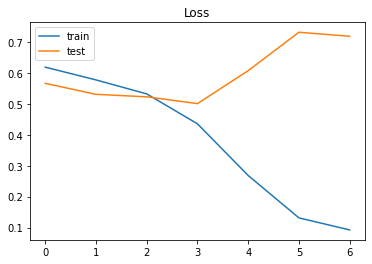

In [17]:
plt.title("Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

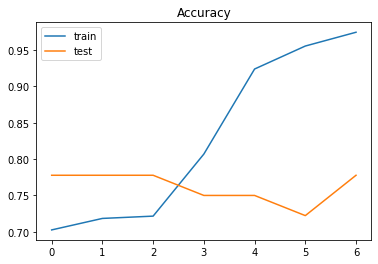

In [18]:
plt.title("Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.legend()
plt.show()

In [19]:
kf = KFold(n_splits=5, shuffle=True)
losses = []
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)],
    )

    accr = model.evaluate(X_test, Y_test)

    y_prediction = model.predict(X_test)
    print("\n==== Classification Report ====")
    print(classification_report(Y_test, y_prediction.round()))
    print("\n\n")
    accuracies.append(accr[1])
    losses.append(accr[0])

    print("Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}".format(accr[0], accr[1]))

print("\n\n")
mean_accuracy = np.mean(accuracies)
print("Average Accuracy: ", mean_accuracy)
std_accuracy = np.std(accuracies)
print("Standard Deviation Accuracy: ", std_accuracy)
print("\n\n")
mean_loss = np.mean(losses)
print("Average Loss: ", mean_loss)
std_loss = np.std(losses)
print("Standard Deviation Loss: ", std_loss)

Epoch 1/50
20/20 [==============================] - 13s 469ms/step - loss: 0.6351 - accuracy: 0.7057 - val_loss: 0.6251 - val_accuracy: 0.6944
Epoch 2/50
20/20 [==============================] - 9s 451ms/step - loss: 0.5675 - accuracy: 0.7310 - val_loss: 0.6326 - val_accuracy: 0.6944
Epoch 3/50
20/20 [==============================] - 9s 456ms/step - loss: 0.5207 - accuracy: 0.7310 - val_loss: 0.6095 - val_accuracy: 0.6944
Epoch 4/50
20/20 [==============================] - 9s 449ms/step - loss: 0.4151 - accuracy: 0.7911 - val_loss: 0.6010 - val_accuracy: 0.6944
Epoch 5/50
20/20 [==============================] - 11s 565ms/step - loss: 0.2481 - accuracy: 0.9209 - val_loss: 0.5479 - val_accuracy: 0.7222
Epoch 6/50
20/20 [==============================] - 9s 449ms/step - loss: 0.1621 - accuracy: 0.9842 - val_loss: 0.6702 - val_accuracy: 0.7222
Epoch 7/50
20/20 [==============================] - 9s 458ms/step - loss: 0.0765 - accuracy: 0.9810 - val_loss: 0.8264 - val_accuracy: 0.6944
Epoc

3/3 [==============================] - 1s 83ms/step

==== Classification Report ====
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        19
           1       0.82      0.84      0.83        69

    accuracy                           0.73        88
   macro avg       0.58      0.58      0.58        88
weighted avg       0.72      0.73      0.72        88




Test set
  Loss: 0.684
  Accuracy: 0.727
Epoch 1/50
20/20 [==============================] - 15s 587ms/step - loss: 0.6137 - accuracy: 0.7319 - val_loss: 0.6866 - val_accuracy: 0.6111
Epoch 2/50
20/20 [==============================] - 9s 451ms/step - loss: 0.5810 - accuracy: 0.7350 - val_loss: 0.7037 - val_accuracy: 0.6111
Epoch 3/50
20/20 [==============================] - 9s 455ms/step - loss: 0.5219 - accuracy: 0.7350 - val_loss: 0.7242 - val_accuracy: 0.6111
Epoch 4/50
3/3 [==============================] - 0s 75ms/step - loss: 0.4980 - accuracy: 0.7614


3/3 [==============================] - 0s 73ms/step

==== Classification Report ====
              precision    recall  f1-score   support

           0       0.83      0.20      0.32        25
           1       0.76      0.98      0.86        63

    accuracy                           0.76        88
   macro avg       0.79      0.59      0.59        88
weighted avg       0.78      0.76      0.70        88




Test set
  Loss: 0.498
  Accuracy: 0.761



Average Accuracy:  0.7097293257713317
Standard Deviation Accuracy:  0.03506199516443391



Average Loss:  0.706676983833313
Standard Deviation Loss:  0.13996471343871608
